# IMPORTAMOS LA LIBRERIAS NECESARIAS

In [1]:
import pandas as pd

In [2]:
from ftfy import fix_text
from rapidfuzz import process, fuzz

### Cargamos la data

In [3]:
df_sitios = pd.read_parquet('../../data/raw/g-sitios.parquet')

In [4]:
# Una copia del dataframe, para evitar demora en carga desde el disco
df_sitios_ = df_sitios.copy()
df_sitios_.sample()

,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
2216363,VIP TRANSLATION & IMMIGRATION SVCS,"VIP TRANSLATION & IMMIGRATION SVCS, 11501 Broo...",0x80dd2844b8604c45:0xdf165c5f15a231fc,None,33.795535,-117.959139,[Park],4.2,5,None,None,None,None,"[0x80dd28419df2bc99:0x407472496701bcb4, 0x80dc...",https://www.google.com/maps/place//data=!4m2!3...


In [ ]:
# Funsion para hacer un explode en aquellas columnas que contienen listas de datos.
def explode_columna(df: pd.DataFrame, columna_a_explodar: str) -> pd.DataFrame:
    return df.explode(columna_a_explodar)

# Funsion para filtrar la categoria que vayamos a usar de acuerdo al tipo de estudio de eleccion.
def filtrar_por_categoria(df: pd.DataFrame, columna_a_filtrar: str, keyword: str) -> pd.DataFrame:
    df = df.dropna(subset=[columna_a_filtrar])
    return df[df[columna_a_filtrar].str.contains(keyword, case=False)]

Eliminacion de columnas no-util

In [5]:
# Descartar col `state` por ser no-util,
# y prevenir confucion con la columna a crear de estados
# del mismo nombre `state`
df_sitios_.drop('state', axis=1, inplace=True)

# Descartar col `url` por ser no-util
df_sitios_.drop('url', axis=1, inplace=True)

Extraccion datos en columna `address`

In [6]:
# Definir el patrón regex para extraer la dirección, ciudad, estado y código postal
patron = r'([^,]+),\s*([^,]+),\s*([^,]+),\s*([^,]+)$'

# Aplicar el regex a cada entrada de la columna "address" y almacenar los resultados en columnas separadas
resultados = df_sitios_['address'].str.extract(patron)

# Asignar los resultados a nuevas columnas en el DataFrame
df_sitios_['name'] = resultados[0].str.strip()
df_sitios_['address'] = resultados[1].str.strip()
df_sitios_['city'] = resultados[2].str.strip()
df_sitios_['state_postal_code'] = resultados[3].str.strip()

# Dividir la columna "Codigo_Postal" en dos nuevas columnas: "state" y "postal_code"
df_sitios_[['state', 'postal_code']] = df_sitios_['state_postal_code'].str.split(' ', n=1, expand=True)

# Descartar col `state_postal_code` que queda redundante
df_sitios_.drop('state_postal_code', axis=1, inplace=True)

---
Filtro por estado

- opcion #1

In [25]:
# Crear una lista de los estados con los prefijos deseados
filtro_estados = ['PA', 'NJ', 'DE']

# Filtrar el DataFrame para incluir solo las filas que tengan estados con los prefijos deseados
df_sitios_ = df_sitios_[df_sitios_['state'].isin(filtro_estados)]

- opcion #2

In [22]:
# Crear una lista de los estados con los prefijos deseados
filtro_estados = [
    "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
    "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]

# Filtrar el DataFrame para incluir solo las filas que tengan estados con los prefijos deseados
df_sitios_ = df_sitios_[df_sitios_['state'].isin(filtro_estados)]

In [8]:
# Contar los valores repetidos en la columna "Estado"
conteo_estados = df_sitios_['state'].value_counts()

# Mostrar el conteo de estados repetidos
print(conteo_estados)

state
CA    285101
TX    252922
FL    208185
NY    156229
PA    110579
IL    100682
OH     97551
GA     92519
NC     92499
MI     87180
NJ     74553
VA     67304
WA     65348
TN     61971
AZ     57106
IN     56968
CO     56620
MO     55091
MA     53043
WI     52323
MN     46076
SC     46027
MD     44130
AL     42940
OR     42504
OK     38930
LA     37068
KY     36122
UT     31043
CT     29116
IA     28554
AR     27507
KS     26635
NV     25421
MS     21464
NM     18946
ID     18853
NE     17604
NH     13994
ME     13896
WV     13765
MT     12089
HI     10895
RI      8787
DE      8194
SD      8033
AK      7483
ND      7310
VT      6740
WY      6429
Name: count, dtype: int64


---
Filtro por categoria "Restaurant"

In [9]:
# Convertir col `category` a typo list
df_sitios_['category'] = df_sitios_['category'].apply(lambda x: x.tolist() if x is not None else None)

In [10]:
def filtrar_palabra(lista_palabras, filtro_string):
    filtro_string_lower = filtro_string.lower()
    return any(filtro_string_lower == p.lower() for s in lista_palabras for p in s.split())

In [11]:
# Filtrar dataframe donde col `category` == 'restaurant'
filtro_categoria = 'restaurant'
df_sitios_ = df_sitios_[df_sitios_['category'].apply(lambda x: filtrar_palabra(x, filtro_categoria) if x is not None else False)]

In [12]:
df_sitios_.shape

(195020, 16)

---
Validacion cruzada con datos Yelp

In [56]:
# Carga data `business` de Yelp
df_yelp_business = pd.read_parquet('../../data/clean/y_business_CLEAN.parquet')
df_yelp_business.sample()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,categories,hours
86526,2jbu_xi_FEghI37kPG5LzA,McDonald's,1660 State Hwy 38,Mount Holly,NJ,08060,39.981863,-74.780123,2.0,25,"[Burgers, Food, Coffee & Tea, Restaurants, Fas...","{'Friday': '0:0-0:0', 'Monday': '0:0-0:0', 'Sa..."


In [57]:
# Funcion que implementa busqueda 'fuzzy' en textos
def fuzzy_match(x, match_to, threshold=90):
    match, score, _ = process.extractOne(x, match_to, scorer=fuzz.WRatio)
    return match if score >= threshold else None

In [58]:
# Funcion que aplica fuzzy_match() entre una columna
# de un dataframe y una lista de entrada
def filtrar_df_fuzzy_match(df: pd.DataFrame, col_match: str, lista_filtro: list) -> pd.DataFrame:
    """Devuelve un dataframe aplica fuzzy_match() entre una columna
    de un dataframe y una lista de entrada
    """
    # Crear nueva columna con valores que hacen match
    df[f'{col_match}_match'] = df[col_match].apply(fuzzy_match, match_to=lista_filtro)
    # Filtrar nulos (donde nulo representa no-match)
    df = df[df[f'{col_match}_match'].notnull()]
    # Descartar columna creada
    df.drop(f'{col_match}_match', axis=1, inplace=True)

    return df

---
Filtro ciudad

In [16]:
# Lista de ciudades unicas en dataset Yelp
ciudades_yelp = set(df_yelp_business['city'].unique().tolist())
len(ciudades_yelp)

578

- Filtro ciudad, metodo #1

In [17]:
df_sitios_ = filtrar_df_fuzzy_match(df_sitios_, 'city', ciudades_yelp)
df_sitios_['city'].nunique()

/tmp/ipykernel_17764/1407594334.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(f'{col_match}_match', axis=1, inplace=True)


332

- Filtro ciudad, metodo #2

In [18]:
# Filtrar el DataFrame original para incluir solo las filas con ciudades que están en la lista de ciudades únicas
df_filtrado2 = df_sitios_[df_sitios_['city'].isin(ciudades_yelp)]

In [19]:
df_filtrado2.sample()

,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,relative_results,city,state,postal_code
767866,Little Caesars Pizza,2695 S Broad St,0x89c1596889f536fb:0xb1c87e4167ea5eff,"Carry-out chain featuring chicken wings, signa...",40.191155,-74.713298,"[Pizza restaurant, Pizza Takeout]",3.3,8,$,"[[Monday, 11AM–10PM], [Tuesday, 11AM–10PM], [W...","{'Accessibility': None, 'Activities': None, 'A...","[0x89c1591eabfbcf4d:0xbbc408e9e8e398f9, 0x89c1...",Trenton,NJ,08610


In [20]:
# Contar el número de ciudades únicas en el nuevo DataFrame
num_ciudades_unicas = df_filtrado2['city'].nunique()

# Mostrar el resultado
print("Número de ciudades únicas en el nuevo DataFrame:", num_ciudades_unicas)

Número de ciudades únicas en el nuevo DataFrame: 256


In [ ]:
# Contar cuántos elementos hay en la lista de ciudades únicas
num_ciudades_unicas_lista = len(ciudades_yelp)

# Mostrar el resultado
print("Número de ciudades únicas en la lista:", num_ciudades_unicas_lista)

- --END-- filtro ciudad

DELETE

In [21]:
df_sitios_.to_pickle('df_sitios_1.pkl')

In [38]:
df_sitios_ = pd.read_pickle('df_sitios_1.pkl')

---
Filtro name & address

In [59]:
# Diccionario de marcas de Darden y competidores
filtro_cadenas = [
    "Olive Garden Italian Restaurant",
    "LongHorn Steakhouse",
    "Cheddar's Scratch Kitchen",
    "Yard House",
    "The Capital Grille",   ####
    "Seasons 52",
    "Bahama Breeze",
    "Eddie V's",  ####
    "Ruth's Chris Steak House"
    "Outback Steakhouse",
    "Carrabba's Italian Grill",
    "Bonefish Grill",
    "Fleming's Prime Steakhouse & Wine Bar",
    "Aussie Grill",
    "Aussie Grill - Brandon"
    "Chili's",
    "Chili's Grill & Bar",
    "Maggiano's Little Italy",
    "It's Just Wings"
    "Texas Roadhouse",
    "Bubba's 33"
]

In [31]:
"""# Lista de conjunto nombre-direccion en dataset Yelp
name_yelp = df_yelp_business['name']
name_yelp = set(name_yelp.tolist())
len(name_yelp)"""

7513

In [60]:
# Crear columna con conjunto de nombre y direccion
#df_sitios_['name_address'] = df_sitios_['name'] + ' ' + df_sitios_['postal_code']
# Aplicar el match fuzzy
df_sitios_ = filtrar_df_fuzzy_match(df_sitios_, 'name', filtro_cadenas)
df_sitios_['name'].nunique()

/tmp/ipykernel_17764/1407594334.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(f'{col_match}_match', axis=1, inplace=True)


49

In [61]:
df_sitios_['name'].value_counts().to_csv('filtro_name_sitios_.csv')

In [24]:
df_yelp_business.shape

(10203, 12)

- --END-- filtro address

---
Filtro nombre

In [ ]:
# Lista de ciudades unicas en dataset de Yelp
name_yelp = set(df_yelp_business['name'].unique().tolist())
len(name_yelp)

In [ ]:
df_sitios_['name_match'] = df_sitios_['name'].apply(fuzzy_match, match_to=name_yelp)
# Filtrar nulos (donde nulo representa no-match)
df_sitios_ = df_sitios_[df_sitios_['name_match'].notnull()]
df_sitios_.drop('name_match', axis=1, inplace=True)
df_sitios_['name'].value_counts()

---
Inspeccion de duplicados

In [ ]:
df_sitios_[df_sitios_['gmap_id'].duplicated()][['gmap_id','category']].to_csv('dupe_gmap_id.csv')

- No existen duplicados reales
---

In [ ]:
# Eliminar duplicados de la columna 'gmap_id'
df_sin_duplicados = df_filtrado2.drop_duplicates(subset=['gmap_id'])

# Resetear el índice del DataFrame resultante
df_sin_duplicados.reset_index(drop=True, inplace=True)

In [ ]:
# Contar los valores nulos en la columna 'Category'
valores_nulos_category = df_filtrado2['category'].isnull().sum()

# Mostrar el resultado
print("Número de valores nulos en la columna 'Category':", valores_nulos_category)

In [ ]:
# Filtrar el DataFrame para mostrar solo las filas donde 'Category' es nulo
valores_nulos_df = df_sin_duplicados[df_sin_duplicados['category'].isnull()]

# Mostrar el DataFrame resultante
print(valores_nulos_df['category'])

In [ ]:
# Eliminar filas con valores nulos en la columna 'Category' y resetear el índice
df = df_sin_duplicados.dropna(subset=['category']).reset_index(drop=True)

In [ ]:
df.info()

In [ ]:
#df.to_parquet("../../data/metadata_google.parquet")

In [ ]:
#df_pennsylvania =  df[df['Estado'] == 'PA'][['gmap_id']]
#df_delaware = df[df['Estado'] == 'DE'][['gmap_id']]
#df_new_jersey = df[df['Estado'] == 'NJ'][['gmap_id']]

In [ ]:
#df_pennsylvania.to_parquet('../../data/PA.parquet')
#df_delaware.to_parquet('../../data/DE.parquet')
#df_new_jersey.to_parquet('../../data/NJ.parquet')

In [ ]:
# Filtrar el segundo DataFrame para incluir solo las filas con los ID que están en el primer DataFrame
#datos_filtrados = df_p[df2['id_establecimiento'].isin(df1['id_establecimiento'])]

## Mapa

In [15]:
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [13]:
df_sitios_.columns

Index(['name', 'address', 'gmap_id', 'description', 'latitude', 'longitude',
       'category', 'avg_rating', 'num_of_reviews', 'price', 'hours', 'MISC',
       'relative_results', 'city', 'state', 'postal_code'],
      dtype='object')

In [28]:
def crear_plot_mapa(df: pd.DataFrame) -> plt.Figure:
    """Devuelve una grafica tipo plt.Figure, con un Shapefile que
    presenta el territorio de USA, y el dataframe de entrada con
    columnas de coordinadas ('longitude', 'latitude').
    """
    # Descartar los nulos
    df = df.dropna(axis=0, subset=['longitude', 'latitude'])

    # Crear un GeoDataFrame con la data de coordinadas
    geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
    gdf = GeoDataFrame(df, geometry=geometry)

    # Cargar archivo shapefile
    mapa = gpd.read_file('../../assets/map_state_5m.shp')

    # Calculamos los limites del mapa
    minx, miny, maxx, maxy = gdf.total_bounds

    # Creamos los plots del mapa
    plt.figure()  # limpiar memory de plotly
    fig, ax = plt.subplots(figsize=(100, 80))
    mapa.plot(ax=ax, color='white', edgecolor='black')
    gdf.plot(ax=ax, marker='o', color='red', markersize=.1)

    # Calculamos el margen del grafico
    margin_ratio = 0.2
    marginx = (maxx - minx) * margin_ratio
    marginy = (maxy - miny) * margin_ratio
    # Aplicamos los margenes en relacion a los plots en los extremos
    ax.set_xlim(minx - marginx, maxx + marginx)
    ax.set_ylim(miny - marginy, maxy + marginy)

    return plt

<Figure size 640x480 with 0 Axes>

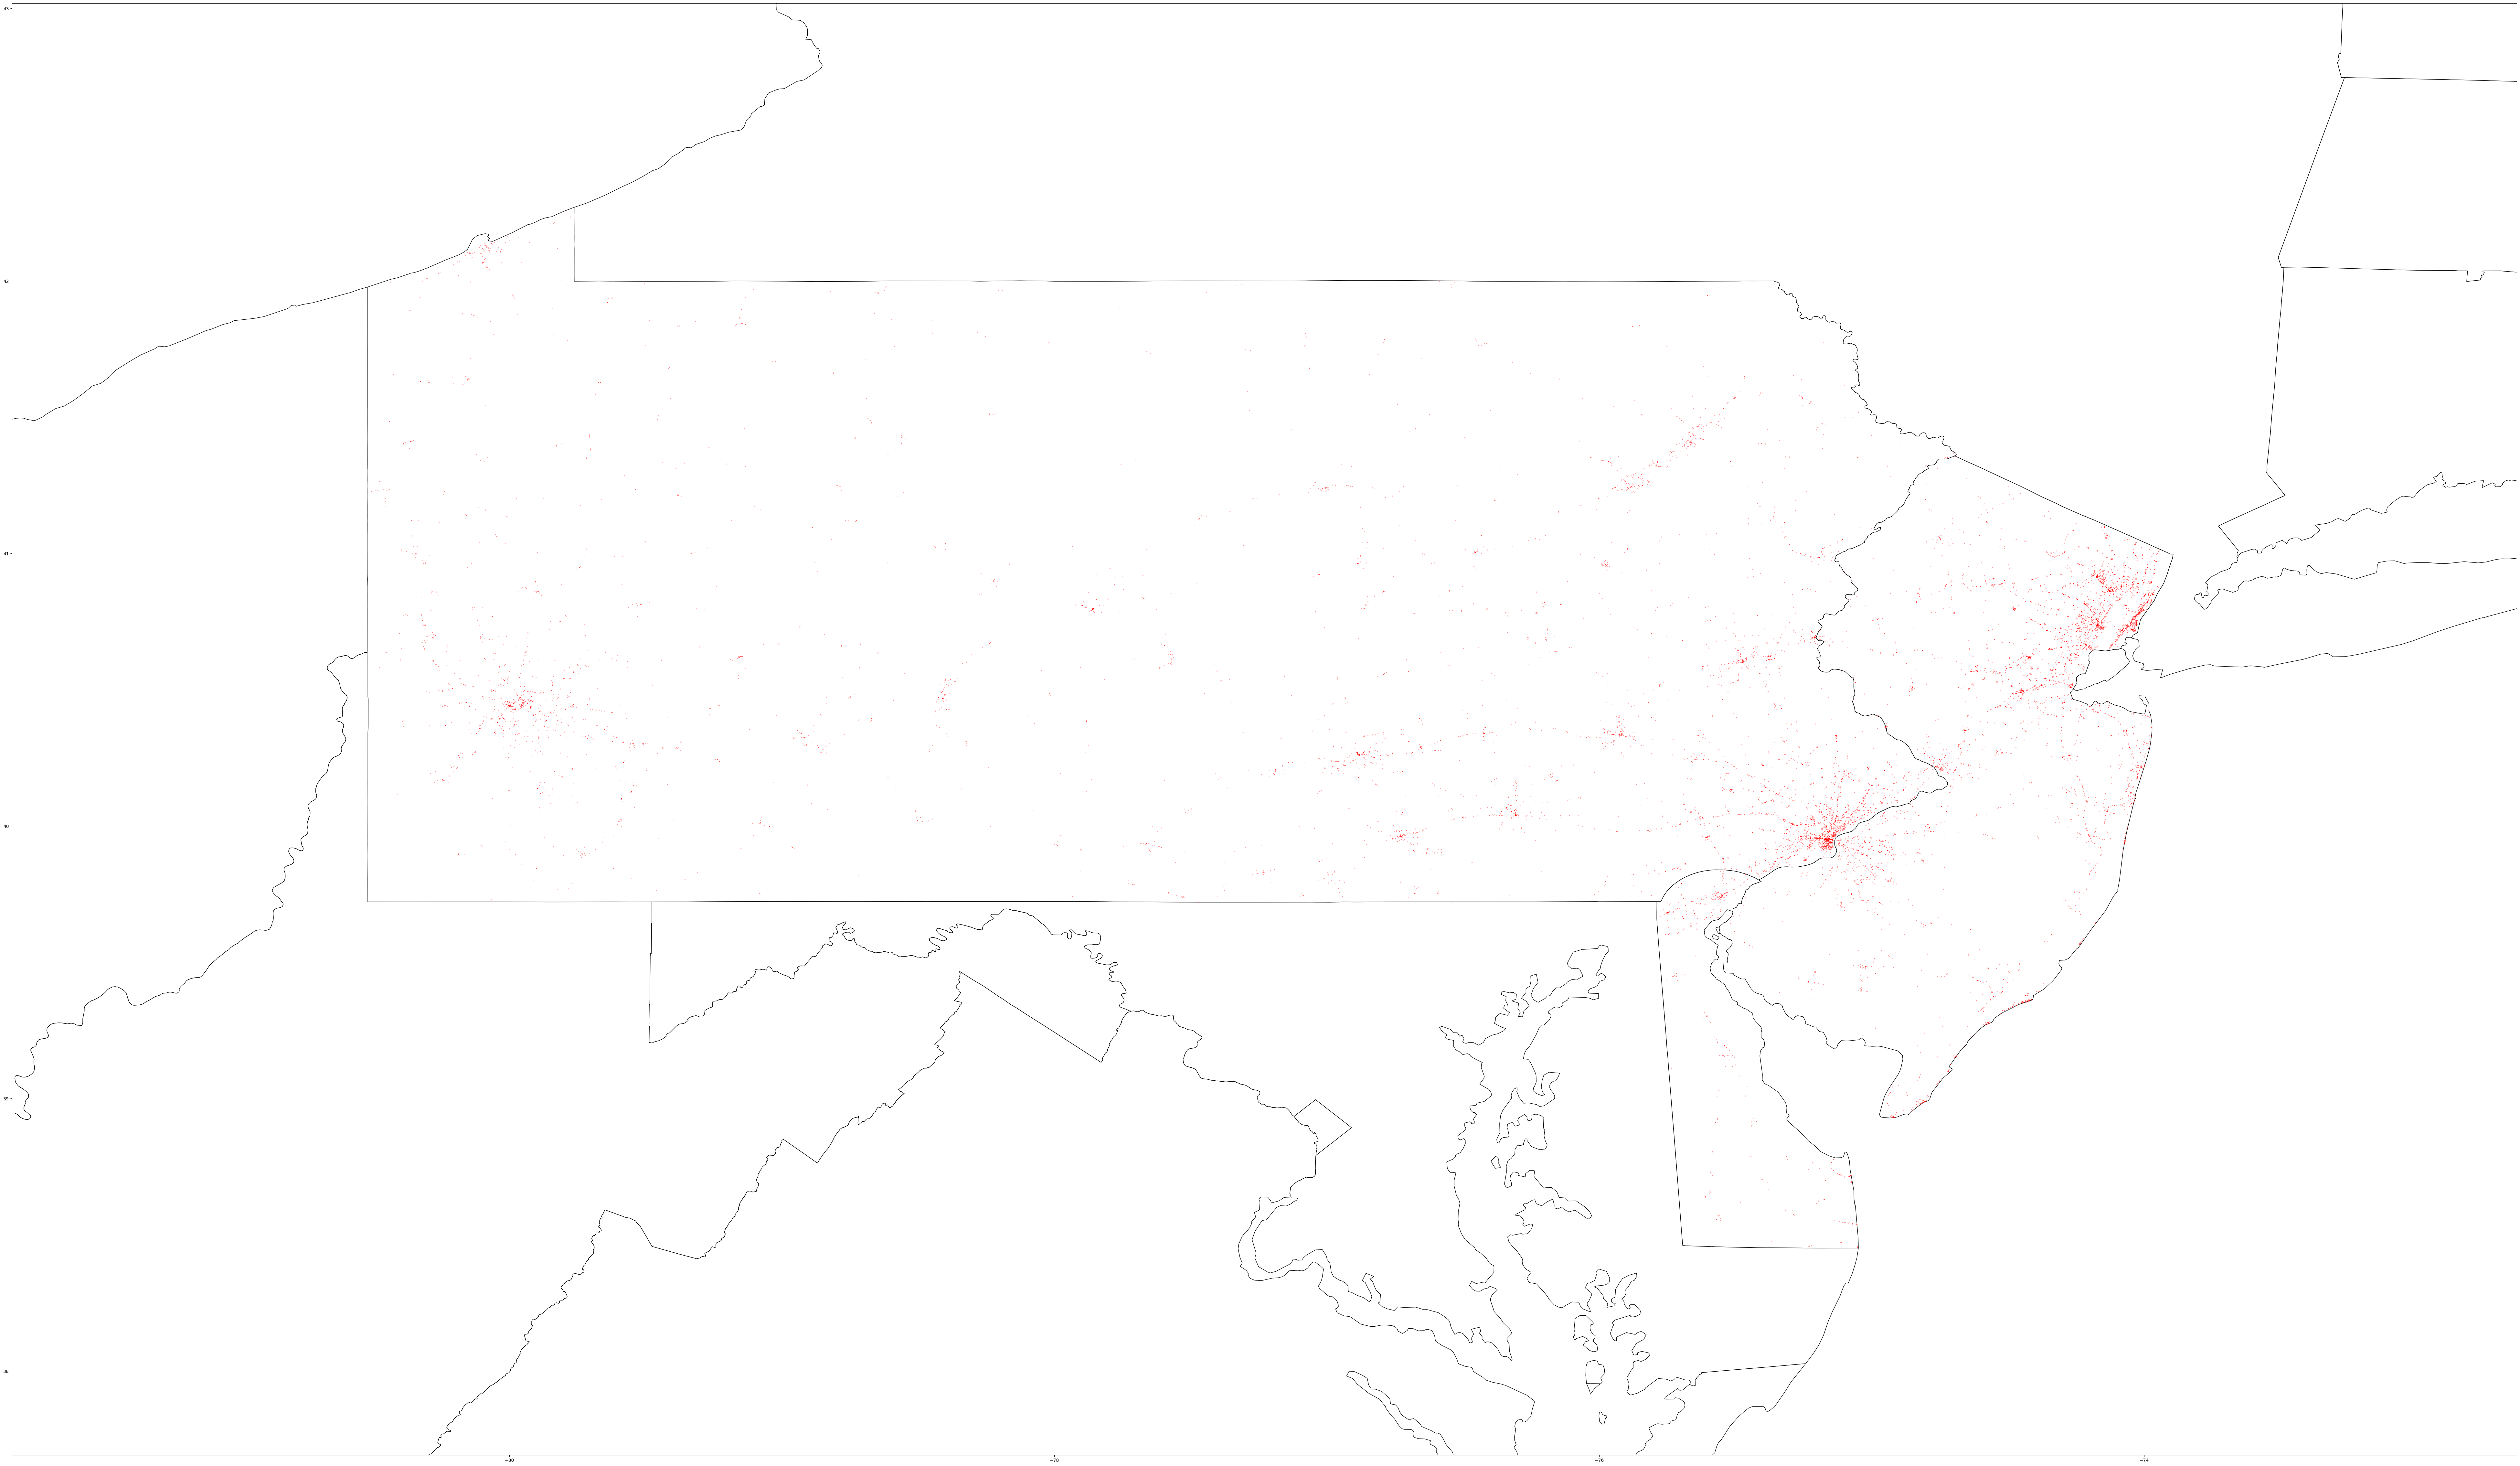

In [29]:
mapa_business = crear_plot_mapa(df_sitios_)
mapa_business.show()